In [ ]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark &> /dev/null

In [ ]:
# importing libraries
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import json
import requests
from pyspark.sql.functions import max as Fmax

from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import round as Fround
from pyspark.sql.functions import isnan, when, count, col, isnull, to_timestamp
from pyspark.sql import SQLContext
from urllib.request import Request, urlopen
from pyspark.sql import Window
from plotly import graph_objs as go

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import feature, regression, evaluation, Pipeline, classification

In [ ]:
# Enable grid for best parameters
enable_grid_search = False

In [ ]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()
sc = spark.sparkContext

# Data Cleaning and Exploratory Data Analysis

In [ ]:
# importing and reading data
r = requests.get("https://udacity-dsnd.s3.amazonaws.com/sparkify/mini_sparkify_event_data.json")
data = [json.loads(line) for line in r.iter_lines()]

In [ ]:
# creating dataframe
df = sc.parallelize(data).map(lambda x: json.dumps(x))
df = spark.read.json(df)

In [ ]:
print("rows:", df.count(), ", cols:", len(df.columns)) #shape of the dataset

rows: 286500 , cols: 18


In [ ]:
# checking schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [ ]:
df = df.withColumn("userId", df["userId"].cast('long')) #converting userId to long datatype

In [ ]:
display(df.show(5)) #first 5 rows of dataset

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

None

In [ ]:
# statistical summary
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

In [ ]:
# checking for missing values
df.select([count(when((isnan(c) | isnull(c)), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [ ]:
#description of artist column
df.describe('artist').show() 

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [ ]:
#description of page column
df.describe('page').show() 

+-------+-------+
|summary|   page|
+-------+-------+
|  count| 286500|
|   mean|   null|
| stddev|   null|
|    min|  About|
|    max|Upgrade|
+-------+-------+



In [ ]:
#description of sessionID column
df.describe('sessionId').show() 

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630786|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [ ]:
#Different pages a user can land on
df.select('page').distinct().collect() 

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [ ]:
# dropping user and session id columns
df_without_missing_id = df.dropna(how = "any", subset = ["userId", "sessionId"])
print("rows:", df_without_missing_id.count(), ", cols:", len(df_without_missing_id.columns))
print("{} rows have been removed.".format(df.count() - df_without_missing_id.count()))

rows: 278154 , cols: 18
8346 rows have been removed.


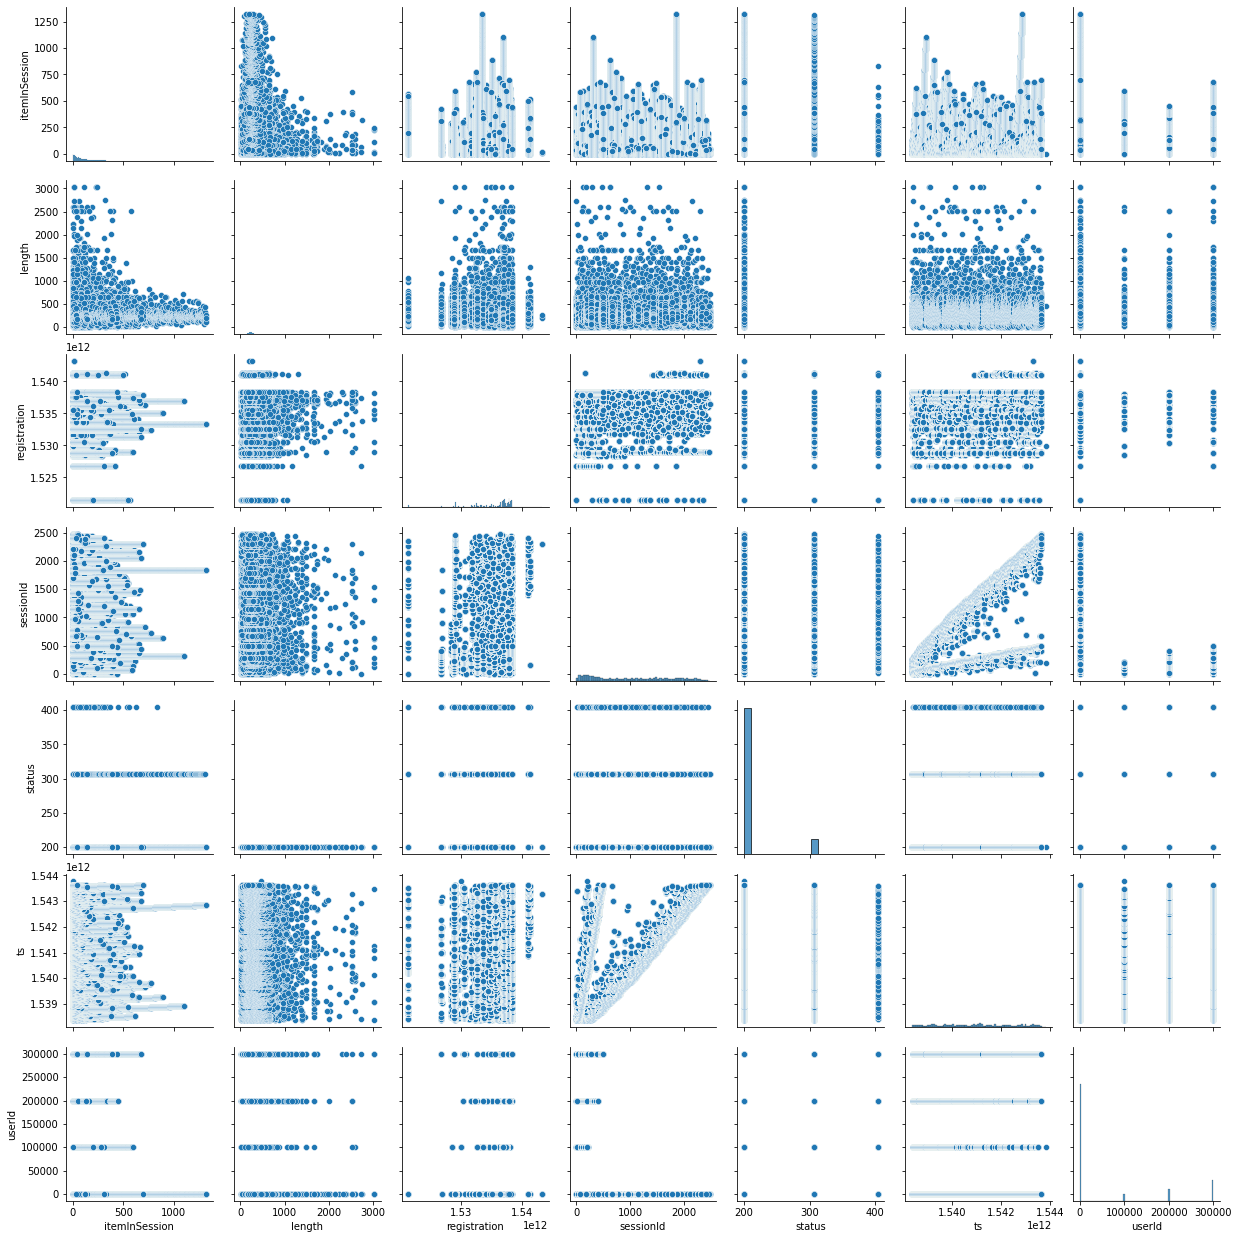

In [ ]:
# plotting to check correlation
df_pandas = df.toPandas() #converting to pandas for plotting
sns.pairplot(df_pandas) #creation of pairplot
plt.show()

In [ ]:
# checking for categorical and numeric type columns
cat_columns = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_columns = [item[0] for item in df.dtypes if (item[1].startswith('bigint') | item[1].startswith('double'))]

In [ ]:
#categorical columns
cat_columns

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent']

In [ ]:
#numerical columns
num_columns

['itemInSession',
 'length',
 'registration',
 'sessionId',
 'status',
 'ts',
 'userId']

**Numerical Columns Analysis**

In [ ]:
#description of all the numeric column
df_without_missing_id.describe(num_columns).show()

+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+------------------+
|summary|     itemInSession|            length|        registration|         sessionId|            status|                  ts|            userId|
+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+------------------+
|  count|            278154|            228108|              278154|            278154|            278154|              278154|            278154|
|   mean|114.89918174824018|249.11718197783722|1.535358834085629...|1042.5616241362698|209.10321620397335|1.540958915431820...| 59682.02278593872|
| stddev|129.85172939948987| 99.23517921058352|3.2913216163279233E9| 726.5010362219855|30.151388851327827| 1.506828712332243E9|109091.94999910615|
|    min|                 0|           0.78322|       1521380675000|                 1|               200|       15383

**Categorical Columns Analysis**

In [ ]:
#description of all the categorical column
df_without_missing_id.describe(cat_columns).show()

+-------+------------------+---------+---------+------+--------+------+-----------------+------+-------+--------------------+--------------------+
|summary|            artist|     auth|firstName|gender|lastName| level|         location|method|   page|                song|           userAgent|
+-------+------------------+---------+---------+------+--------+------+-----------------+------+-------+--------------------+--------------------+
|  count|            228108|   278154|   278154|278154|  278154|278154|           278154|278154| 278154|              228108|              278154|
|   mean| 551.0852017937219|     null|     null|  null|    null|  null|             null|  null|   null|            Infinity|                null|
| stddev|1217.7693079161374|     null|     null|  null|    null|  null|             null|  null|   null|                 NaN|                null|
|    min|               !!!|Cancelled| Adelaida|     F|   Adams|  free|       Albany, OR|   GET|  About|ÃÂg ÃÂtti

**Target Variable Creation**

In [ ]:
flag_churned_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType()) #defining UDF to create target column
df_churned = df_without_missing_id.withColumn("churned", flag_churned_event("page")) #creating new column from the results of UDf

In [ ]:
df_churned.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churned|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|      0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...

In [ ]:
#churn rate percentage
churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
print("churned percentage of users is: {:.2f}%".format(churned_rate * 100))

churned percentage of users is: 23.11%


In [ ]:
# windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
# df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))
# df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

In [ ]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn') #churned users
df_churn_user = df_churned.groupby("userId").max("churned").withColumnRenamed("max(churned)", "churn").select(["userId", "churn"])

In [ ]:
df_churn_user.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    29|    1|
|    26|    0|
|    65|    0|
|    54|    1|
|    19|    0|
+------+-----+
only showing top 5 rows



In [ ]:
# Exploring date and location registered for all users
to_datestr = f.udf(lambda t: datetime.datetime.fromtimestamp(t / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
is_cancelled = f.udf(lambda page: 1 if page == 'Cancellation Confirmation' else 0, IntegerType())
w = Window.partitionBy('userId')
df_log = df_without_missing_id.withColumn('churnEvent', is_cancelled(f.col('page'))) \
                 .withColumn('churn', f.max(f.col('churnEvent')).over(w)) \
                 .withColumn('ds', f.to_date(to_datestr(f.col('ts')))) \
                 .withColumn('dsRegistration', f.to_date(to_datestr(f.col('registration')))) \
                 .withColumn("locCities", f.split(df.location, ',').getItem(0)) \
                 .withColumn("locCity", f.split(f.col('locCities'), '-').getItem(0)) \
                 .drop('churnEvent','locCities')

df_log.dropDuplicates(subset=['userId']).select(['userId', 'churn', 'ds', 'dsRegistration', 'locCity']).show(3) #dropping duplicates
df_log.printSchema()

+------+-----+----------+--------------+---------+
|userId|churn|        ds|dsRegistration|  locCity|
+------+-----+----------+--------------+---------+
|     2|    0|2018-10-08|    2018-09-13|  Raleigh|
|     3|    1|2018-10-03|    2018-08-10|  Bozeman|
|     4|    0|2018-10-01|    2018-09-28|Baltimore|
+------+-----+----------+--------------+---------+
only showing top 3 rows

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-

In [ ]:
fig_colors = {'churned':'rgba(200, 80, 2, 0.8)', 'stayed':'rgba(0,100,0,0.5)'}
def draw_barplot(x, y_churned, y_stayed, topic=''): 
    y_total = []
    y_total.append(int(y_churned[0] + y_stayed[0]))
    y_total.append(int(y_churned[1] + y_stayed[1]))
    
    trace1 = go.Bar(
        name="Churned", 
        x=x,  
        y=y_churned,
        text=[f"Churn Rate: {100*(cnt/(total+1e-10)) :.2f}%<br>" \
              for cnt,total in zip(y_churned,y_total)], 
        textposition='auto',
        hovertext = [f"Churn Rate: {100*(cnt/(total+1e-10)) :.2f}%<br>" \
                     + f"Churned Users: {cnt :.0f} / {total :.0f}" 
                     for cnt,total in zip(y_churned,y_total)], 
        marker=dict(color=fig_colors['churned']), 
        opacity=0.75, 
    )

    trace2 = go.Bar(
        name="Stayed", 
        x=x,  
        y=y_stayed,
        text=[f"Stay Rate: {100*(cnt/(total+1e-10)) :.2f}%" for cnt,total in zip(y_stayed,y_total)], 
        textposition='auto',
        hovertext = [f"Churn Rate: {100*(cnt/(total+1e-10)) :.2f}%<br>" \
                     + f"Churned Users: {cnt :.0f} / {total :.0f}" 
                     for cnt,total in zip(y_stayed,y_total)], 
        marker=dict(color=fig_colors['stayed']), 
        opacity=0.75, 
    )

    layout = dict(
        barmode = 'stack', 
        hovermode = 'x', 
        title = dict(
            text=f'The Churn Analysis: {topic}',
            x=0.5, 
            y=0.95,
            xanchor='center',
            yanchor='top', 
            font_size=25, 
        ),
        yaxis_title = 'Number of Users',
        legend = dict(
            orientation='h', 
            x=0.5, 
            y=1.15,
            xanchor='center',
            yanchor='top', 
        ), 
        plot_bgcolor = 'rgb(243,243,243)', 
        paper_bgcolor = 'rgb(243,243,243)', 
        font = dict(
            family='Times New Roman', 
            size=15,
        )
    )

    fig = go.Figure(data=[trace2, trace1], layout=layout)

    for item, total in zip(x, y_total): 
        fig.add_annotation(
            x=item, y=total, yshift=25,showarrow=False,
            text=f"Total in {item}: {total}",
        )

    return fig
def draw_timeplot(x, y_churned, y_stayed, topic=''): 
    offset = 15
    trace1 = go.Scatter(
        name="Churned", 
        x=x,  
        y=np.array(y_churned) + np.array(y_stayed) - offset,
        marker=dict(color=fig_colors['churned'], symbol='square', size=15), 
        line=dict(color=fig_colors['churned'], width=2, dash='dash'), 
        showlegend=False,
        hoverinfo='none'
    )

    trace2 = go.Scatter(
        name="Stayed", 
        x=x,  
        y=np.array(y_stayed) - offset,
        marker=dict(color=fig_colors['stayed'], symbol='square', size=15), 
        line=dict(color=fig_colors['stayed'], width=2, dash='dash'), 
        showlegend=False,
        hoverinfo='none'
    )
    
    fig = draw_barplot(x, y_churned, y_stayed, topic=topic)
    for trace in fig['data']: 
        trace['textposition'] = 'none'
    
    # add lineplots 
    fig.add_traces([trace1, trace2])
    
    # add annotations
    for xi, yi, shift, value in zip(trace1['x'], trace1['y'], [-30, +30], y_churned): 
        fig.add_annotation(
            x=xi, y=yi, xshift=shift,showarrow=False,
            text=f'{value:.0f}',
            font=dict(color=fig_colors['churned'])
        )
    for xi, yi, shift, value in zip(trace2['x'], trace2['y'], [-30, +30], y_stayed): 
        fig.add_annotation(
            x=xi, y=yi, xshift=shift,showarrow=False,
            text=f'{value:.0f}',
            font=dict(color=fig_colors['stayed'])
        )
    
    return fig
def draw_barplot(x, y_churned, y_stayed, topic=''): 
    """ draw a stacked bar plot for two user groupbs (churned and stayed) 
        using plotly library 
    [Args] 
        x (list): the data list for x axis
        y_churned (list) : the y axis data for 'churned' trace
        y_stayed (list): the y axis data for 'stayed' trace
        topic (str): the str used for title 
    [Returns] 
        fig (obj): plotly go.Figure() object 
    """
    y_total = []
    y_total.append(int(y_churned[0] + y_stayed[0]))
    y_total.append(int(y_churned[1] + y_stayed[1]))
    
    trace1 = go.Bar(
        name="Churned", 
        x=x,  
        y=y_churned,
        text=[f"Churn Rate: {100*(cnt/(total+1e-10)) :.2f}%<br>" \
              for cnt,total in zip(y_churned,y_total)], 
        textposition='auto',
        hovertext = [f"Churn Rate: {100*(cnt/(total+1e-10)) :.2f}%<br>" \
                     + f"Churned Users: {cnt :.0f} / {total :.0f}" 
                     for cnt,total in zip(y_churned,y_total)], 
        marker=dict(color=fig_colors['churned']), 
        opacity=0.75, 
    )

    trace2 = go.Bar(
        name="Stayed", 
        x=x,  
        y=y_stayed,
        text=[f"Stay Rate: {100*(cnt/(total+1e-10)) :.2f}%" for cnt,total in zip(y_stayed,y_total)], 
        textposition='auto',
        hovertext = [f"Churn Rate: {100*(cnt/(total+1e-10)) :.2f}%<br>" \
                     + f"Churned Users: {cnt :.0f} / {total :.0f}" 
                     for cnt,total in zip(y_stayed,y_total)], 
        marker=dict(color=fig_colors['stayed']), 
        opacity=0.75, 
    )

    layout = dict(
        barmode = 'stack', 
        hovermode = 'x', 
        title = dict(
            text=f'The Churn Analysis: {topic}',
            x=0.5, 
            y=0.95,
            xanchor='center',
            yanchor='top', 
            font_size=25, 
        ),
        yaxis_title = 'Number of Users',
        legend = dict(
            orientation='h', 
            x=0.5, 
            y=1.15,
            xanchor='center',
            yanchor='top', 
        ), 
        plot_bgcolor = 'rgb(243,243,243)', 
        paper_bgcolor = 'rgb(243,243,243)', 
        font = dict(
            family='Times New Roman', 
            size=15,
        )
    )

    fig = go.Figure(data=[trace2, trace1], layout=layout)

    for item, total in zip(x, y_total): 
        fig.add_annotation(
            x=item, y=total, yshift=25,showarrow=False,
            text=f"Total in {item}: {total}",
        )

    return fig

def stack_bars_horizontally(figs, topics=""):
    """ draw a combined multiple bar plots 
        using plotly library 
    [Args] 
        figs (list of objs): list of go.Figure() object to combine 
        topics (str): the str used for title 
    [Returns] 
        fig (obj): plotly go.Figure() object 
    """
    # Combine bar plots horizontaly 
    if not topics:
        topics = ', '.join([str(f.data[0].y0) for f in figs]) 
    
    fig_bars = go.Figure().set_subplots(rows=1, cols=len(figs), shared_yaxes=True)

    for i, fig in enumerate(figs): 
        fig_bars.add_trace(fig.data[0], row=1, col=i+1)
        fig_bars.add_trace(fig.data[1], row=1, col=i+1)
        fig_bars.update_xaxes(fig.layout.xaxis, row=i+1, col=1)
        fig_bars.update_yaxes(fig.layout.yaxis, row=i+1, col=1)

        if i < (len(figs)-1): 
            fig_bars.update_traces(showlegend=False)

        fig_bars.add_annotation(fig.layout.annotations[0], row=1, col=i+1)
        fig_bars.add_annotation(fig.layout.annotations[1], row=1, col=i+1)


    fig_bars.update_layout(dict(
        barmode = 'stack', 
        hovermode = 'x', 
        title = dict(
            text=f'Churn Analysis: ' + topics,
            x=0.5, 
            y=0.95,
            xanchor='center',
            yanchor='top', 
            font_size=25, 
        ),
        yaxis_title = 'Number of Users',
        legend = dict(
            orientation='h', 
            x=0.5, 
            y=1.15,
            xanchor='center',
            yanchor='top', 
        ), 
        plot_bgcolor = 'rgb(243,243,243)', 
        paper_bgcolor = 'rgb(243,243,243)', 
        font = dict(
            family='Times New Roman', 
            size=15,
        ),
    ))

    return fig_bars

In [ ]:
print(f'The shape of the raw data: {df.toPandas().shape}')
print(f'The shape of the clean data: {df_without_missing_id.toPandas().shape}')
print(f'The shape of the log data: {df_log.toPandas().shape}')

total_users = df_log.dropDuplicates(["userId"]).count()
churned_users = df_log.where(f.col('churn')==1).dropDuplicates(['userId']).count()
stayed_users = df_log.where(f.col('churn')==0).dropDuplicates(['userId']).count()
print(f'The number of users (unique userId): {total_users}')  
print(f"The count of churned users (1): {churned_users}")
print(f"The count of Not-Churned users (0): {stayed_users}")

log_period = df_log.select(f.min('ds'), f.max('ds')).first()
print(f'The logging period: {log_period[0]} - {log_period[1]}')


The shape of the raw data: (286500, 18)
The shape of the clean data: (278154, 18)
The shape of the log data: (278154, 22)
The number of users (unique userId): 225
The count of churned users (1): 52
The count of Not-Churned users (0): 173
The logging period: 2018-10-01 - 2018-12-03


In [ ]:
# churn rate per month 
df_oct_log = df_log.where((df_log['ds'] >= datetime.date(2018, 10, 1)) & (df_log['ds'] < datetime.date(2018, 11, 1)))
df_nov_log = df_log.where((df_log['ds'] >= datetime.date(2018, 11, 1)) & (df_log['ds'] < datetime.date(2018, 12, 1)))

# total count of users across oct and nov 
y_usercount = []
y_usercount.append(df_oct_log.dropDuplicates(["userId"]).count())
y_usercount.append(df_nov_log.dropDuplicates(["userId"]).count())

y_churnrate = [] 
y_churnrate.append(df_oct_log.dropDuplicates(['userId']).select(f.mean('churn')).collect()[0][0])
y_churnrate.append(df_nov_log.dropDuplicates(['userId']).select(f.mean('churn')).collect()[0][0])

# Plot
x = ['October', 'November']
y_churned = [cnt*rate for cnt,rate in zip(y_usercount, y_churnrate)]
y_stayed = [cnt*(1-rate) for cnt,rate in zip(y_usercount, y_churnrate)]
fig_time = draw_timeplot(x, y_churned, y_stayed, topic='Time')
fig_time.show()

In [ ]:
pd_gender = df_log.groupBy(['gender', 'churn']) \
                   .agg(f.count('churn').alias('churnCnt')) \
                   .orderBy('gender') \
                   .toPandas()

x = ['Female', 'Male'] 
y_churned = pd_gender[pd_gender.churn == 1]["churnCnt"].tolist() #[femaleChurned, maleChurned]
y_stayed = pd_gender[pd_gender.churn == 0]["churnCnt"].tolist() #[femaleStayed, maleStayed]

fig_gender = draw_barplot(x, y_churned, y_stayed, topic='Gender')

In [ ]:
pd_level = df_log.groupBy(['level', 'churn']) \
                   .agg(f.count('churn').alias('churnCnt')) \
                   .orderBy('level') \
                   .toPandas()

x = ['Free', 'Paid'] 
y_churned = pd_level[pd_level.churn == 1]["churnCnt"].tolist()
y_stayed = pd_level[pd_level.churn == 0]["churnCnt"].tolist()

fig_level = draw_barplot(x, y_churned, y_stayed, topic='Subscription Level')

In [ ]:
figs = [fig_gender, fig_level]
fig_bars = stack_bars_horizontally(figs, topics='Gender And Subscription Level')
fig_bars.show()

In [ ]:
# # 1. Churn Analysis: Time 

# # churn rate per month 
# df_oct_log = df_churned.where((df_log['ds'] >= datetime.date(2018, 10, 1)) & (df_churned['ds'] < datetime.date(2018, 11, 1)))
# df_nov_log = df_churned.where((df_log['ds'] >= datetime.date(2018, 11, 1)) & (df_churned['ds'] < datetime.date(2018, 12, 1)))

# # total count of users across oct and nov 
# y_usercount = []
# y_usercount.append(df_oct_log.dropDuplicates(["userId"]).count())
# y_usercount.append(df_nov_log.dropDuplicates(["userId"]).count())

# y_churnrate = [] 
# y_churnrate.append(df_oct_log.dropDuplicates(['userId']).select(f.mean('churn')).collect()[0][0])
# y_churnrate.append(df_nov_log.dropDuplicates(['userId']).select(f.mean('churn')).collect()[0][0])

# # Plot
# x = ['October', 'November']
# y_churned = [cnt*rate for cnt,rate in zip(y_usercount, y_churnrate)]
# y_stayed = [cnt*(1-rate) for cnt,rate in zip(y_usercount, y_churnrate)]
# fig_time = draw_timeplot(x, y_churned, y_stayed, topic='Time')
# fig_time.show()


#Feature Engineering

In [ ]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))
df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

In [ ]:
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+--------+------+-------------+-------+-----+-----+
|userId|gender|level|    page|status|           ts|churned|phase|churn|
+------+------+-----+--------+------+-------------+-------+-----+-----+
|     3|     M| paid|NextSong|   200|1538532534000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538532844000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538533012000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538533261000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538533448000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538533687000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538533919000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538534220000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538534405000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538534680000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538534939000|      0|    0

In [ ]:
df_churn.filter(df_churn["churn"] == 1).select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+--------+------+-------------+-------+-----+-----+
|userId|gender|level|    page|status|           ts|churned|phase|churn|
+------+------+-----+--------+------+-------------+-------+-----+-----+
|     3|     M| paid|NextSong|   200|1538532534000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538532844000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538533012000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538533261000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538533448000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538533687000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538533919000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538534220000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538534405000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538534680000|      0|    0|    1|
|     3|     M| paid|NextSong|   200|1538534939000|      0|    0

In [ ]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
print("churned user count: {} (total: {})".format(churned_user_count, df_churn.count()))
print("churned user rate: {:.2f}%".format(churned_user_count / df_churn.count() * 100))

churned user count: 52 (total: 278154)
churned user rate: 0.02%


In [ ]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

In [ ]:
df_churn_user = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

In [ ]:
pd_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_gender.head()

,userId,gender,churn
0,2,F,Not Churn
1,2,F,Not Churn
2,2,F,Not Churn
3,2,F,Not Churn
4,2,F,Not Churn


In [ ]:
df_churn.show(1)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+-------+-----+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|page| registration|sessionId|song|status|           ts|           userAgent|userId|churned|phase|churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+-------+-----+-----+
|  null|Logged In|   Joseph|     M|            2|  Medina|  null| free|Phoenix-Mesa-Scot...|   GET|Home|1537456136000|      380|null|   200|1538581469000|"Mozilla/5.0 (Win...|     5|      0|    0|    0|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+------

In [ ]:
df_original = df_churn.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")

In [ ]:
df_original.show(10)

+------+------+
|userId|target|
+------+------+
|     2|     0|
|     3|     1|
|     4|     0|
|     5|     0|
|     6|     0|
|     7|     0|
|     8|     0|
|     9|     0|
|    10|     0|
|    11|     0|
+------+------+
only showing top 10 rows



In [ ]:
#artist count per userid
user_artist = df_churn.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
user_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|    29|        3028|
|    26|         255|
|    65|        2113|
|    54|        2841|
|    19|         216|
+------+------------+
only showing top 5 rows



In [ ]:
# gender
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_churn_with_gender = df_churn.withColumn("gender", flag_gender("gender"))
df_churn_with_gender.show(1)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+-------+-----+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|page| registration|sessionId|song|status|           ts|           userAgent|userId|churned|phase|churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+-------+-----+-----+
|  null|Logged In|   Joseph|     0|            2|  Medina|  null| free|Phoenix-Mesa-Scot...|   GET|Home|1537456136000|      380|null|   200|1538581469000|"Mozilla/5.0 (Win...|     5|      0|    0|    0|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+------

In [ ]:
user_gender = df_churn_with_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    29|     0|
|    26|     0|
|    65|     0|
|    54|     1|
|    19|     1|
+------+------+
only showing top 5 rows



In [ ]:
# total length of users
user_length = df_churn.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
user_length.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|    29| 754517.5625700008|
|    26| 65236.15544999998|
|    65|      529357.90542|
|    54| 711344.9195400006|
|    19|54480.933869999986|
+------+------------------+
only showing top 5 rows



In [ ]:
# number of thumbs up
user_thumbs_up = df_churn.filter(df_churn["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
user_thumbs_up.show(5)

+------+--------+
|userId|thumb_up|
+------+--------+
|    29|     154|
|    26|      12|
|    65|     111|
|    54|     163|
|    19|       5|
+------+--------+
only showing top 5 rows



In [ ]:
# number of thumbs down
user_thumbs_down = df_churn.filter(df_churn["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")
user_thumbs_down.show(5)

+------+----------+
|userId|thumb_down|
+------+----------+
|    29|        22|
|    26|         1|
|    65|        17|
|    54|        29|
|    19|         2|
+------+----------+
only showing top 5 rows



In [ ]:
# flagging paid and free users
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_churn_with_level = df_churn.withColumn("level", flag_level("level"))
df_churn_with_level.show(1)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+-------+-----+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|page| registration|sessionId|song|status|           ts|           userAgent|userId|churned|phase|churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+-------+-----+-----+
|  null|Logged In|   Joseph|     M|            2|  Medina|  null|    0|Phoenix-Mesa-Scot...|   GET|Home|1537456136000|      380|null|   200|1538581469000|"Mozilla/5.0 (Win...|     5|      0|    0|    0|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----+-------------+---------+----+------+-------------+--------------------+------+------

In [ ]:
user_level = df_churn_with_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    29|    1|
|    26|    1|
|    65|    1|
|    54|    1|
|    19|    1|
+------+-----+
only showing top 5 rows



In [ ]:
# songs per userID
user_song = df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")
user_song.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|    29|      3028|
|    26|       255|
|    65|      2113|
|    54|      2841|
|    19|       216|
+------+----------+
only showing top 5 rows



In [ ]:
# joining all features
merged_df = df_original.join(user_artist, ['userId']) \
    .join(user_gender, ['userId']) \
    .join(user_length, ['userId']) \
    .join(user_level, ['userId']) \
    .join(user_thumbs_up, ['userId']) \
    .join(user_thumbs_down, ['userId']) \
    .join(user_song, ['userId'])

In [ ]:
merged_df.printSchema()

root
 |-- userId: long (nullable = true)
 |-- target: integer (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- gender: integer (nullable = true)
 |-- length: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- thumb_up: long (nullable = false)
 |-- thumb_down: long (nullable = false)
 |-- song_count: long (nullable = false)



In [ ]:
merged_df.show(5)

+------+------+------------+------+------------------+-----+--------+----------+----------+
|userId|target|artist_count|gender|            length|level|thumb_up|thumb_down|song_count|
+------+------+------------+------+------------------+-----+--------+----------+----------+
|    29|     1|        3028|     0| 754517.5625700008|    1|     154|        22|      3028|
|    26|     0|         255|     0| 65236.15544999998|    1|      12|         1|       255|
|    65|     0|        2113|     0|      529357.90542|    1|     111|        17|      2113|
|    54|     1|        2841|     1| 711344.9195400006|    1|     163|        29|      2841|
|    19|     0|         216|     1|54480.933869999986|    1|       5|         2|       216|
+------+------+------------+------+------------------+-----+--------+----------+----------+
only showing top 5 rows



In [ ]:
merged_df.select('level').distinct().collect()

[Row(level=1), Row(level=0)]

# Modeling

## Logistic Regression


In [ ]:
merged_df

DataFrame[userId: bigint, target: int, artist_count: bigint, gender: int, length: double, level: int, thumb_up: bigint, thumb_down: bigint, song_count: bigint]

In [ ]:
merged_df = merged_df.dropna() #dropping null values

In [ ]:
train, validation, test = merged_df.randomSplit([.6,.1,.2]) #splitting data into test, train, validation sets

In [ ]:
from pyspark.ml.regression import RandomForestRegressor 
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer, StringIndexer,OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from sklearn.model_selection import GridSearchCV
from pyspark.ml.regression import RandomForestRegressor 
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from sklearn.model_selection import GridSearchCV
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

In [ ]:
va = VectorAssembler(inputCols=['artist_count','length','thumb_up','thumb_down','song_count'], outputCol='features') #collecting features for model

In [ ]:
oheg = OneHotEncoder(inputCol='gender',outputCol='gender_oh') #one hot encoding gender

In [ ]:
ohel = OneHotEncoder(inputCol='level',outputCol='level_oh') #one hot encoding level

In [ ]:
vaf = VectorAssembler(inputCols=['features','gender_oh','level_oh'],outputCol='final_features') #collecting final features for model

In [ ]:
lr = LogisticRegression(labelCol='target',featuresCol='final_features', regParam = 0.01) #setting features, target column for logistic regression 

In [ ]:
pipe=Pipeline(stages=[va,oheg,ohel,vaf,lr]) #creating pipeline

In [ ]:
pipe_fit = pipe.fit(train) #fitting pipeline

In [ ]:
trans=pipe_fit.transform(test) #testing pipeline

In [ ]:
trans.toPandas().head()

,userId,target,artist_count,gender,length,level,thumb_up,thumb_down,song_count,features,gender_oh,level_oh,final_features,rawPrediction,probability,prediction
0,8,0,251,1,63393.53191,0,16,3,251,"[251.0, 63393.531909999976, 16.0, 3.0, 251.0]",(0.0),(1.0),"[251.0, 63393.531909999976, 16.0, 3.0, 251.0, ...","[1.4736814623785568, -1.4736814623785568]","[0.8136163053842783, 0.18638369461572168]",0.0
1,14,0,1230,0,304778.64878,1,54,12,1230,"[1230.0, 304778.64877999993, 54.0, 12.0, 1230.0]",(1.0),(0.0),"[1230.0, 304778.64877999993, 54.0, 12.0, 1230....","[0.946501975719958, -0.946501975719958]","[0.7204111532614194, 0.27958884673858064]",0.0
2,30,0,1417,0,359808.24564,1,62,17,1417,"[1417.0, 359808.24563999975, 62.0, 17.0, 1417.0]",(1.0),(0.0),"[1417.0, 359808.24563999975, 62.0, 17.0, 1417....","[0.9552400212143752, -0.9552400212143752]","[0.7221677666298152, 0.2778322333701848]",0.0
3,33,0,1257,0,310709.85425,1,79,9,1257,"[1257.0, 310709.85425, 79.0, 9.0, 1257.0]",(1.0),(0.0),"[1257.0, 310709.85425, 79.0, 9.0, 1257.0, 1.0,...","[1.4294886978786328, -1.4294886978786328]","[0.8068216364726961, 0.1931783635273039]",0.0
4,37,0,1412,0,354702.17113,1,75,11,1412,"[1412.0, 354702.1711299998, 75.0, 11.0, 1412.0]",(1.0),(0.0),"[1412.0, 354702.1711299998, 75.0, 11.0, 1412.0...","[1.3370188048367473, -1.3370188048367473]","[0.7919992574883442, 0.2080007425116558]",0.0


In [ ]:
bce = BinaryClassificationEvaluator(labelCol='target')

In [ ]:
bce.evaluate(pipe_fit.transform(validation)) #evaluating AUC

0.5

In [ ]:
#auc score of 0.5 for logistic regression model 

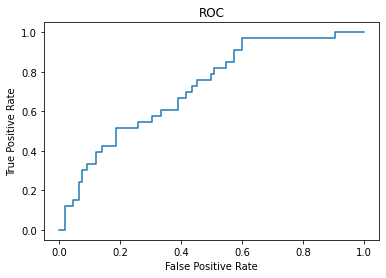

In [ ]:
# your code here
#roc plot for logisitc model
fpr = pipe_fit.stages[-1].summary.roc.select('FPR').toPandas()
tpr = pipe_fit.stages[-1].summary.roc.select('TPR').toPandas()
plt.plot(fpr,tpr)
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()     

In [ ]:
lr_model = pipe_fit.stages[-1]

In [ ]:
pd.DataFrame(list(zip(merged_df.columns[2:], lr_model.coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight') #variables and their coefficient from the regrssion

,column,weight
6,song_count,-4.395574e-01
2,length,-1.547454e-02
0,artist_count,-5.004474e-05
4,thumb_up,-5.004474e-05
1,gender,-3.377718e-07
3,level,3.047249e-02
5,thumb_down,5.809228e-01


# Random Forest

In [ ]:
rf = RandomForestClassifier(labelCol='target',featuresCol='final_features') #setting features, target column for random forest

In [ ]:
rf_pipe = Pipeline(stages=[va,oheg,ohel,vaf,rf]) #building  pipeline

In [ ]:
rf_pipe_fit = rf_pipe.fit(train) #fitting pipeline

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.8/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
rf_trans = rf_pipe_fit.transform(test) #testing pipeline

In [ ]:
rf_trans.toPandas().head()

In [ ]:
bce.evaluate(rf_pipe_fit.transform(validation))

In [ ]:
#auc is 0.54, very low

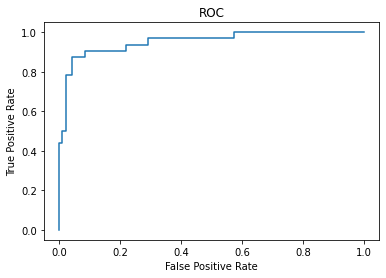

In [ ]:
#roc plot for random forest model
fpr2 = rf_pipe_fit.stages[-1].summary.roc.select('FPR').toPandas()
tpr2 = rf_pipe_fit.stages[-1].summary.roc.select('TPR').toPandas()
plt.plot(fpr2,tpr2)
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
rf_model = rf_pipe_fit.stages[-1]

In [ ]:
pd.DataFrame(list(zip(merged_df.columns[2:], rf_model.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight') #variables and their feature importance from the random forest model

,column,weight
6,song_count,0.023321
5,thumb_down,0.033648
1,gender,0.114717
4,thumb_up,0.142891
3,level,0.222937
2,length,0.224788
0,artist_count,0.237698


# Modeling with Hyperparamter Tuning

In [ ]:
# building cross validation model

if enable_grid_search:

  def build_model(classifier, param):

    # creating feature columns
    feature_columns = [col for col in merged_df.columns if col!='target']
  
    # train-test split
    train, test = merged_df.randomSplit([0.7, 0.3])

    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])  

    # creating cross validation
    model = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param,
    evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1'),
    numFolds=5,
    )
    return model

In [ ]:
# tuning logistic regression

if enable_grid_search:

  lr = LogisticRegression(featuresCol='scaled_features', labelCol = 'target')
  
  # creating grid
  grid = ParamGridBuilder().\
  addGrid(lr.regParam, [0, 0.01, 0.2]).\
  addGrid(lr.elasticNetParam, [0.1, 0.2, 0.5]).\
  build()
  
  # building the model
  lr_model = build_model(lr, grid)
 
  # training lr model
  fit_lr_model = lr_model.fit(train)
  
  # fitting the best model
  best_lr_model = fit_lr_model.bestModel
  best_lr_model.stages[2].save("lr_tuned")

  # prediction
  best_lr_model_pred = best_lr_model.transform(test)
  best_lr_model_pred.select("prediction").dropDuplicates().collect()

  # creating evaluation metric
  evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1')

  # printing f1 score 
  best_f1_score_lr = evaluator.evaluate(best_lr_model_pred, {evaluator.metricName: "f1"})
  print("f1 for logistic regression: {}".format(best_f1_score_lr))

f1 for logistic regression: 0.6124401913875599


In [ ]:
  # tuning random forest

if enable_grid_search:
  
  classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="target")

  # creating grid
  param_grid = ParamGridBuilder() \
      .addGrid(classifier.maxDepth,[5, 10]) \
      .addGrid(classifier.numTrees, [20, 50]) \
      .build()

  # building the model
  rf_model = build_model(lr, grid)

  # training lr model
  fit_rf_model = rf_model.fit(train) 

  # fitting the best model
  best_rf_model = fit_rf_model.bestModel
  best_rf_model.stages[2].save("rf_tuned")

  # prediction
  best_rf_model_pred = best_rf_model.transform(test)
  best_rf_model_pred.select("prediction").dropDuplicates().collect()

# creating evaluation metric
evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1')

# printing f1 score 
best_f1_score_rf = evaluator.evaluate(best_rf_model_pred, {evaluator.metricName: "f1"})
print("f1 for random forest: {}".format(best_f1_score_rf))

f1 for random forest: 0.6124401913875599
